In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.utils.data as utils
import tqdm as tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
import sys
path = '/Users/gyuhuikwon/Desktop/KHUphy/github/2023_datadist/dataset_2018/data_2018.xlsx'

### prepare data 1 - dataset definition

In [2]:
class ExcelDataset(utils.Dataset):
    def __init__(self, path, variables):
        df = pd.read_excel(path) #(2208,8)
        self.Y = df.values[:,-1] #(2208,1)
        self.Y = LabelEncoder().fit_transform(self.Y)
        self.X = df[variables].values
        self.X = self.X.astype('float32')
        
    def __len__(self): #전체 dataset의 size
        return len(self.X)
    
    def __getitem__(self, idx): #idx번째 데이터 확인할 때 : Dataset[idx]
        return (self.X[idx], self.Y[idx])
    
    def split_data(self, n_train=0.7): #전체 dataset을 랜덤하게 test/train으로 분리
        train_size = round(n_train * len(self.X))
        test_size = len(self.X) - train_size
        return utils.random_split(self, [train_size, test_size])
    
feature_names = ['wind_direction', 'temperature', 'precipitation', 'humidity', 'ground_pressure', 'wind_speed', 'sky_condition']

### prepare data 2 - data processing / split / make batch

In [3]:

def prepare_data(path, batch_size=20):
    dataset = ExcelDataset(path, variables)
    train_data, test_data = dataset.split_data() #dataset 분리 완료 (1546,662)
    #DataLoader로 batch_size로 쪼개기
    train_ld = utils.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False)
    test_ld = utils.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)
    return train_ld, test_ld

In [4]:
for i in range(6):
    plt.hist(xs[:,i], color = 'green', bins = 10, alpha = 0.4, histtype = 'stepfilled')
    plt.title(feature_names[i])
    plt.xlabel('Time(hour)')
    plt.ylabel('Frequency(number)')
    plt.show() 

plt.hist(ys, color = 'blue', alpha = 0.4)
plt.title(feature_names[6]) #1,3,4 중 하나
plt.xlabel('Time(hour)')
plt.ylabel('Frequency(number)')

NameError: name 'xs' is not defined

## multi_classification model

In [5]:
class MLR(nn.Module):
    def __init__(self, n_input=6, n_hidden=8, n_output=1):
        super(MLR, self).__init__()
        self.l1 = nn.Linear(n_input, n_hidden)
        #주어진 레이어의 가중치를 레이어가 정의된 후에 초기화
        init.kaiming_uniform_(self.l1.weight, nonlinearity='relu')
        self.relu1 =  nn.ReLU(inplace=True)
        
        self.l2 = nn.Linear(n_hidden, n_hidden)
        init.kaiming_uniform_(self.l2.weight, nonlinearity='relu')
        self.relu2 =  nn.ReLU(inplace=True)
        
        self.l3 = nn.Linear(n_hidden, n_output)
        init.xavier_uniform_(self.l3.weight)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, X):
        X1 = self.l1(X)
        X2 = self.relu1(X1)
        X3 = self.l2(X2)
        X4 = self.relu2(X3)
        X5 = self.l3(X4)
        X6 = self.softmax(X5)
        return X6    

#model = MLR(5,8,3)
#print(model)

### total for MLP(train, test, acc, graph)

In [11]:
def train_model(train_ld, model):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.0001)
    
    for epoch in range(700):
        for i, (inputs, outputs) in enumerate(train_ld):
            optimizer.zero_grad()
            y_train_pred = model(inputs)
            outputs = outputs.reshape(len(outputs),-1).type(torch.float64)
            loss = criterion(y_train_pred, outputs)
            loss.backward()
            optimizer.step()        

In [7]:
def test_model(test_ld, model): 
    pred_list, act_list = [], []
    for inputs, outputs in test_ld:
        y_test = model(inputs) #type(y_test[idx])=torch.Tensor
        #.detach() : 역전파를 막기 위함
        y_test = y_test.detach().numpy() #type(y_test[idx])=np.ndarray
        y_test_pred = np.argmax(y_test, axis=1) #열에서 가장 높은 값 반환
        y_actual = outputs.numpy()
        
        test = y_test_pred.reshape((len(y_test),1)) # 1 column(일렬)로 정렬
        actual = y_actual.reshape((len(y_actual),1))
        
        pred_list.append(test) #1 column을 가로로 append -> n column
        act_list.append(actual)
        
    predictions, actuals = np.vstack(pred_list), np.vstack(act_list) #세로로 일렬로 합침 -> 1 column
    
    acc = accuracy_score(actuals, predictions)
    return acc

### GetResults.py

In [12]:
#변수는 이미 정해져있고, 하나의 variable에 대해 [variable] [time] [acc]
#variables에 combis의 순서대로 들어가서 결과 내보냄
from time import time
variables = ['wind_direction', 'temperature']
path = '/Users/gyuhuikwon/Desktop/KHUphy/github/2023_datadist/dataset_2018/data_2018.xlsx'
def GetResults(variables):
    start_time= time()
    train_ld, test_ld = prepare_data(path)
    model = MLR(len(variables),5,1)
    train_model(train_ld, model)
    accuracy = test_model(test_ld, model)
    end_time = time()
    total_time = end_time - start_time
    print(f"variables: {variables}, accuracy: {accuracy}, time: {total_time}")
#echo "py" >> result.txt
GetResults(variables)


variables: ['wind_direction', 'temperature'], accuracy: 0.31419939577039274, time: 9.840779066085815


## multi_classification_PCA model

In [254]:
class ExcelDataset_PCA(utils.Dataset):
    def __init__(self, path):
        df = pd.read_excel(path) #(2208,8)
        self.X = df.values[:,2:-1]#(2208,6)
        self.X = self.X.astype('float32')
        self.Y = df.values[:,-1] #(2208,1)
        self.Y = LabelEncoder().fit_transform(self.Y)
        
    def __len__(self): #전체 dataset의 size
        return len(self.X)
    
    def __getitem__(self, idx): #idx번째 데이터 확인할 때 : Dataset[idx]
        return (self.X[idx], self.Y[idx])
    
    def split_data(self, n_train=0.7): #전체 dataset을 랜덤하게 test/train으로 분리
        train_size = round(n_train * len(self.X))
        test_size = len(self.X) - train_size
        return utils.random_split(self.X, [train_size, test_size]), utils.random_split(self.Y, [train_size, test_size])

len of x_train: 1546 / len of y_train: 662
[[  65.    21.     1.4   94.  1000.8    1.4]
 [  54.    20.5   13.8   96.  1000.7    1.4]
 [  65.    20.6   14.7   96.  1000.8    1.4]
 ...
 [ 318.    14.4    0.    54.   995.3    2.2]
 [ 308.    14.5    0.    55.   995.3    2.2]
 [ 318.    16.     0.    50.   994.9    2.6]]
--------------------------------------------------
[[2]
 [2]
 [2]
 ...
 [1]
 [1]
 [0]]


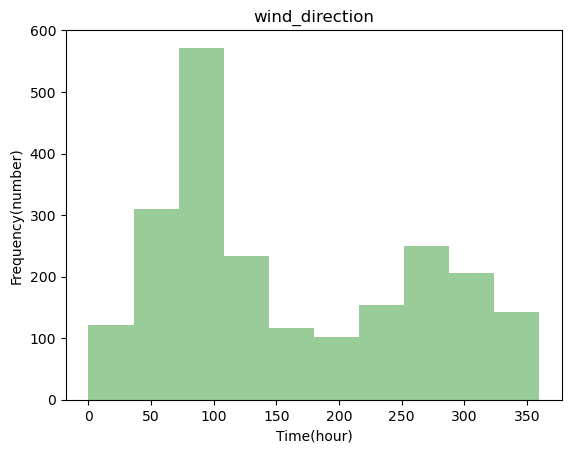

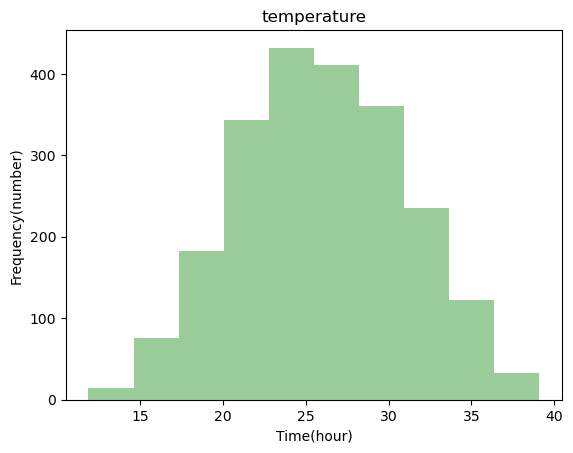

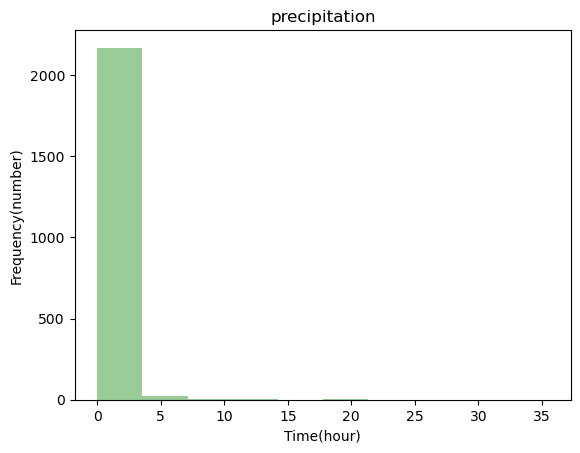

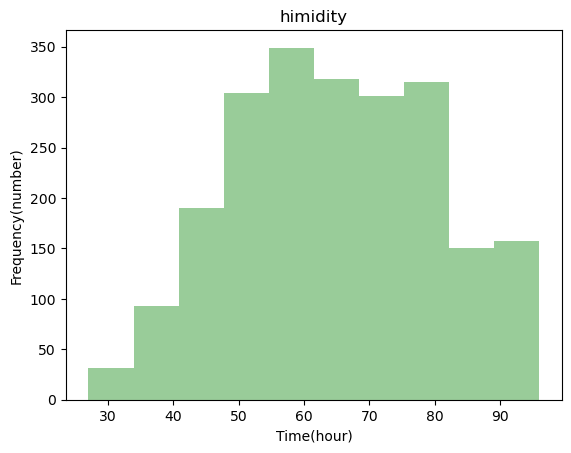

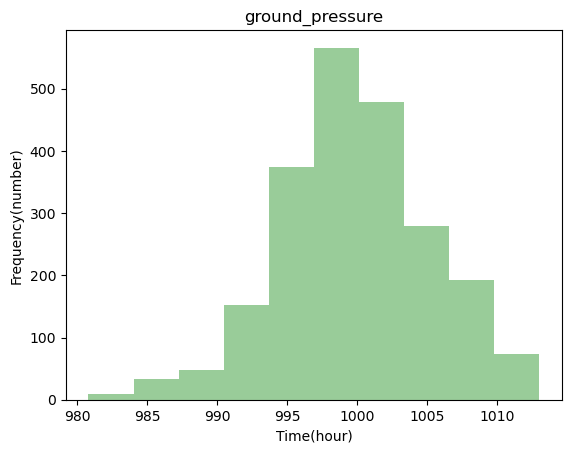

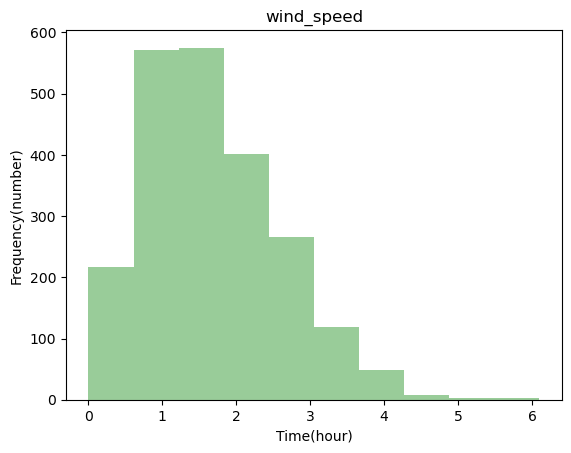

Text(0, 0.5, 'Frequency(number)')

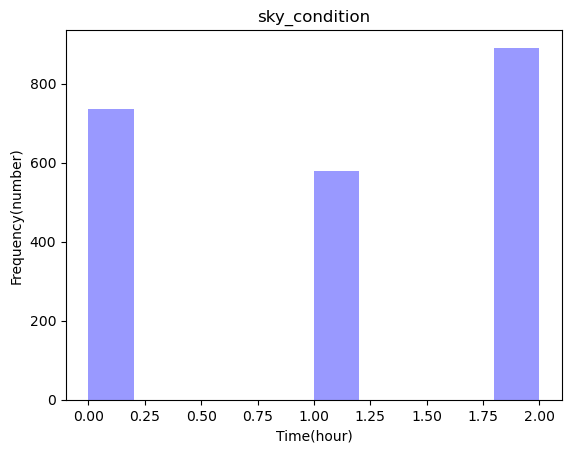

In [255]:
dataset = ExcelDataset_PCA(path)
(x_train, x_test), (y_train, y_test) = dataset.split_data()
print(f"len of x_train: {len(x_train)} / len of y_train: {len(x_test)}") #(1546,6), (662,1)

feature_names = ['wind_direction', 'temperature', 'precipitation', 'himidity', 'ground_pressure', 'wind_speed', 'sky_condition']
xs, ys = dataset.X, dataset.Y
print(xs[:])
print('-'*50)
print(ys.reshape(2208,1))

for i in range(6):
    plt.hist(xs[:,i], color = 'green', bins = 10, alpha = 0.4, histtype = 'stepfilled')
    plt.title(feature_names[i])
    plt.xlabel('Time(hour)')
    plt.ylabel('Frequency(number)')
    plt.show() 

plt.hist(ys, color = 'blue', alpha = 0.4)
plt.title(feature_names[6]) #1,3,4 중 하나
plt.xlabel('Time(hour)')
plt.ylabel('Frequency(number)')

In [295]:
def prepare_data_PCA(path, batch_size=20, n_components=3):
    dataset = ExcelDataset_PCA(path)
    pca = PCA(n_components)
    (x_train, x_test), (y_train, y_test) = dataset.split_data()
    x_train_score = pca.fit_transform(x_train).astype('f') #type=numpy.float32, shape=(1546,3)
    x_test_score = pca.fit_transform(x_test).astype('f')
    train_zip, test_zip = zip(x_train_score, y_train), zip(x_test_score, y_test)
    train_data, test_data = list(train_zip), list(test_zip)
    print(train_data[0])
    pca.components_
    explained_variance = pca.explained_variance_.astype('float16')
    print(explained_variance)
    ratio = pca.explained_variance_ratio_.astype('float16')
    print(ratio)
    train_ld = utils.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False)
    test_ld = utils.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)
    return train_ld, test_ld

train_ld, test_ld = prepare_data_PCA(path,20,6)
print(train_ld.dataset[0])

(array([-69.71526   , -13.659069  ,   3.1151674 ,  -4.8461866 ,
        -0.757819  ,  -0.41265222], dtype=float32), 1)
[9.712e+03 2.351e+02 3.700e+01 1.109e+01 1.315e+00 6.196e-01]
[9.717e-01 2.351e-02 3.700e-03 1.109e-03 1.316e-04 6.199e-05]
(array([-69.71526   , -13.659069  ,   3.1151674 ,  -4.8461866 ,
        -0.757819  ,  -0.41265222], dtype=float32), 1)


In [118]:
class MLR_PCA(nn.Module):
    def __init__(self, n_input=5, n_hidden=8, n_output=3):
        super(MLR_PCA, self).__init__()
        self.l1 = nn.Linear(n_input, n_hidden)
        #주어진 레이어의 가중치를 레이어가 정의된 후에 초기화
        init.kaiming_uniform_(self.l1.weight, nonlinearity='relu')
        self.relu1 =  nn.ReLU(inplace=True)
        
        self.l2 = nn.Linear(n_hidden, n_hidden)
        init.kaiming_uniform_(self.l2.weight, nonlinearity='relu')
        self.relu2 =  nn.ReLU(inplace=True)
        
        self.l3 = nn.Linear(n_hidden, n_output)
        init.xavier_uniform_(self.l3.weight)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, X):
        X1 = self.l1(X)
        X2 = self.relu1(X1)
        X3 = self.l2(X2)
        X4 = self.relu2(X3)
        X5 = self.l3(X4)
        X6 = self.softmax(X5)
        return X6    

#model = MLR(5,8,3)
#print(model)

In [125]:
def train_model_PCA(train_ld, model):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    for epoch in tqdm.tqdm(range(epochs)):
        for i, (inputs, outputs) in enumerate(train_ld):
            optimizer.zero_grad()
            print(outputs.shape)
            print(inputs.shape)
            y_train_pred = model(inputs) # inputs.shape=(20,3)
            #print(y_train_pred.shape)
            outputs = outputs.long()
            loss = criterion(y_train_pred, outputs)
            loss.backward()
            optimizer.step()  
        print(y_train_pred.shape) 
lr=0.01
epochs=10
a = train_model_PCA(train_ld, MLR_PCA(5,8,3))


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([20])
torch.Size([20, 6])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (20x6 and 5x8)

In [175]:
def test_model_PCA(x_test, y_test, model):
    pred_list, act_list = [], []
    for inputs, outputs in zip(x_test, y_test):
        y_test = model(inputs) #type(y_test[idx])=torch.Tensor
        #.detach() : 역전파를 막기 위함
        y_test = y_test.detach().numpy() #type(y_test[idx])=np.ndarray
        y_test_pred = np.argmax(y_test, axis=1) #열에서 가장 높은 값 반환
        y_actual = outputs.numpy()
        
        test = y_test_pred.reshape((len(y_test),1)) # 1 column(일렬)로 정렬
        actual = y_actual.reshape((len(y_actual),1))
        
        pred_list.append(test) #1 column을 가로로 append -> n column
        act_list.append(actual)
        
    predictions, actuals = np.vstack(pred_list), np.vstack(act_list) #세로로 일렬로 합침 -> 1 column
    
    #acc = np.sum(predictions == actuals) / float(len(test_ld.dataset))
    acc = accuracy_score(actuals, predictions)
    return acc

In [176]:
#for epochs in range(100,1000,100):
epochs = 10
n_hidden, lr, n_component = 20, 1e-5, 2
path = '/Users/gyuhuikwon/Desktop/KHUphy/github/2023_datadist/dataset_2018/data_2018.xlsx'
x_train, y_train, x_test, y_test = prepare_data_PCA(path,n_component)
model = MLR_PCA(n_component,n_hidden,3) #input 5개
train_model_PCA(x_train, y_train, model)
accuracy = test_model_PCA(x_test, y_test, model)
print(f"epoch: {epochs}, accuracy: {accuracy}")

[[153.34602     22.563028     4.574703  ]
 [138.91449    -20.78778      0.23420548]
 [119.117065    13.703544    -4.255466  ]
 [188.70209      3.1635983    5.7390356 ]
 [194.74463    -26.707825     0.71118623]]


  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([2])
torch.Size([2, 3])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x3 and 2x20)